In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec
plt.rcParams['savefig.dpi'] = 600
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import LineCollection

## S7 Fig

### Preparing data for the A panel (secondary mutations in 150 paired-end)

In [4]:
# Importing the final selection coefficients for the 150 paired-end F3-F4 libraries
# (no aggregation nor outlier removal performed)
s_150_final = pd.read_csv("s_final/s_150_F3F4_filtered.csv")

# Keeping only the columns of interest
s_150_final = s_150_final[['Genotype', 's_T0toT3_Ref', 'With_CDS_spikeins', 'Condition',
                           'Mutation type', 'Position', 'In F3F4']].copy()
# Selecting mutations outside the F3-F4 region and keeping only samples with 5-FC without spike-ins
s_150_sec = s_150_final[(s_150_final['With_CDS_spikeins'] == False) & (s_150_final['Condition'] == 'WITH_5FC')].copy().reset_index(drop=True)
s_150_sec = s_150_sec[s_150_sec['In F3F4'] == False].copy().reset_index(drop=True)

In [5]:
# Adding a column with FCY1-relative position
# The position of insertions is also adjusted for consistency
s_150_sec['FCY1_position'] = 200
for row in s_150_sec.index:
    current_type = s_150_sec.at[row, 'Mutation type']

    if current_type == 'Insertion':
        s_150_sec.at[row, 'FCY1_position'] = s_150_sec.at[row, 'Position'] + 1 - 154
    else:
        s_150_sec.at[row, 'FCY1_position'] = s_150_sec.at[row, 'Position'] - 154

In [6]:
# Calculating median s
s_150_med = s_150_sec.infer_objects().groupby(by=['Genotype', 'With_CDS_spikeins', 'Condition',
                                                  'Mutation type', 'Position', 'In F3F4', 'FCY1_position'], as_index=False).median()
s_150_min = s_150_sec.infer_objects().groupby(by=['Genotype', 'With_CDS_spikeins', 'Condition',
                                                  'Mutation type', 'Position', 'In F3F4'], as_index=False).min()
s_150_min = s_150_min.rename(columns={'s_T0toT3_Ref': 'Min_s'})
s_150_max = s_150_sec.infer_objects().groupby(by=['Genotype', 'With_CDS_spikeins', 'Condition',
                                                  'Mutation type', 'Position', 'In F3F4', 'FCY1_position'], as_index=False).max()
s_150_max = s_150_max.rename(columns={'s_T0toT3_Ref': 'Max_s'})

s_150_med = pd.merge(s_150_med, s_150_min, on=['Genotype', 'With_CDS_spikeins', 'Condition',
                                               'Mutation type', 'Position', 'In F3F4', 'FCY1_position'])
s_150_med = pd.merge(s_150_med, s_150_max, on=['Genotype', 'With_CDS_spikeins', 'Condition',
                                               'Mutation type', 'Position', 'In F3F4', 'FCY1_position'])

s_150_sec['N_samples'] = 1
s_150_nums = s_150_sec.drop(columns=['s_T0toT3_Ref']).groupby(by=['Genotype', 'With_CDS_spikeins', 'Condition',
                                                                  'Mutation type', 'Position', 'In F3F4', 'FCY1_position'], as_index=False).sum()
s_150_med = pd.merge(s_150_med, s_150_nums, on=['Genotype', 'With_CDS_spikeins', 'Condition',
                                                'Mutation type', 'Position', 'In F3F4', 'FCY1_position'])

In [7]:
s_150_med.sort_values(by=['s_T0toT3_Ref'], ascending=False).head(50)

,Genotype,With_CDS_spikeins,Condition,Mutation type,Position,In F3F4,FCY1_position,s_T0toT3_Ref,Min_s,Max_s,N_samples
10,I-171_1nt_-toG,False,WITH_5FC,Insertion,171,False,18,0.475412,0.464727,0.486097,2
5,D-172_1nt_Gto-,False,WITH_5FC,Deletion,172,False,18,0.472411,0.456085,0.488736,2
4,D-171_1nt_Tto-,False,WITH_5FC,Deletion,171,False,17,0.436158,0.432859,0.439456,2
21,S-160_1nt_GtoT,False,WITH_5FC,Substitution,160,False,6,0.166199,0.105906,0.284034,7
6,D-174_1nt_Cto-,False,WITH_5FC,Deletion,174,False,20,0.157234,0.089415,0.319744,8
33,S-172_1nt_GtoT,False,WITH_5FC,Substitution,172,False,18,0.135226,0.083404,0.267901,7
29,S-168_1nt_GtoT,False,WITH_5FC,Substitution,168,False,14,0.113611,0.089220,0.251655,6
16,S-157_1nt_GtoT,False,WITH_5FC,Substitution,157,False,3,0.109313,0.060318,0.233882,7
27,S-166_1nt_GtoT,False,WITH_5FC,Substitution,166,False,12,0.099290,0.067354,0.106434,5
25,S-164_1nt_GtoT,False,WITH_5FC,Substitution,164,False,10,0.088928,0.063564,0.105113,3


In [8]:
# Grand median of selection coefficients
med_s = np.median(s_150_final['s_T0toT3_Ref'])

In [9]:
med_s

-0.1368207102129948

### Preparing data for the B panel (Sanger sequencing)

In [11]:
data_sanger = pd.read_csv("Data_for_SFigs/5FC_resistance_Sanger.csv")

In [12]:
# Uniformizing the 'Mut_type' annotations
to_change = ['Unknown', 'Unclear', 'Promoter duplication']

data_sanger['Mut_type'] = data_sanger['Mut_type'].apply(lambda x: 'Unknown' if x in to_change else x)


data_sanger = data_sanger.rename(columns={'Fragment': 'Reinsertion'})

In [13]:
# Adjusting the position of mutations
# The numbering is based on the 150 paired-end fragment including the primers,
# so it is offset 20 bp compared to above
data_sanger['FCY1_position'] = 200

for row in data_sanger.index:
    current_type = data_sanger.at[row, 'Mut_type']

    if current_type == 'Single insertion':
        data_sanger.at[row, 'FCY1_position'] = data_sanger.at[row, 'Location'] + 1 - 174
    else:
        data_sanger.at[row, 'FCY1_position'] = data_sanger.at[row, 'Location'] - 174

In [14]:
data_sanger

,Reinsertion,Replicate,Mut_type,Location,FCY1_position
0,F3,1,Unknown,NaN,NaN
1,F3,2,Unknown,NaN,NaN
2,F4,1,Unknown,NaN,NaN
3,F4,1,Single deletion,191.0,17.0
4,F4,1,Single deletion,199.0,25.0
5,F4,1,Single deletion,203.0,29.0
6,F4,1,Single deletion,191.0,17.0
7,F4,1,Single deletion,201.0,27.0
8,F4,1,Single insertion,191.0,18.0
9,F4,2,Single deletion,217.0,43.0


### Constructing the figure

In [16]:
# Shortening the mutation type labels
shorter_dict = {'Substitution': 'Sub', 'Insertion': 'Ins', 'Deletion': 'Del'}
s_150_med['Mutation type'] = s_150_med['Mutation type'].apply(lambda x: shorter_dict[x])

# Obtaining subsets and diffs (for error bars) for each type of mutation (panel A)
sec_sub = s_150_med[s_150_med['Mutation type'] == 'Sub'].copy().reset_index(drop=True)
sub_err =  np.array([sec_sub['s_T0toT3_Ref'] - sec_sub['Min_s'],
                     sec_sub['Max_s'] - sec_sub['s_T0toT3_Ref']])

sec_ins = s_150_med[s_150_med['Mutation type'] == 'Ins'].copy().reset_index(drop=True)
ins_err =  np.array([sec_ins['s_T0toT3_Ref'] - sec_ins['Min_s'],
                     sec_ins['Max_s'] - sec_ins['s_T0toT3_Ref']])

sec_del = s_150_med[s_150_med['Mutation type'] == 'Del'].copy().reset_index(drop=True)
del_err =  np.array([sec_del['s_T0toT3_Ref'] - sec_del['Min_s'],
                     sec_del['Max_s'] - sec_del['s_T0toT3_Ref']])

In [17]:
mut_palette = {'Sub': cm.tab10.colors[9], 
               'Ins': cm.tab20b.colors[1],
               'Del': cm.tab10.colors[3]}

sanger_palette = {'Single substitution': cm.tab10.colors[9], 
                  'Single insertion': cm.tab20b.colors[1],
                  'Single deletion': cm.tab10.colors[3]}

fragments_palette = {'F3': '#427fac', 'F4': '#3f955a'}

plt.rcParams["axes.labelsize"] = 11
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["xtick.labelsize"] = 10

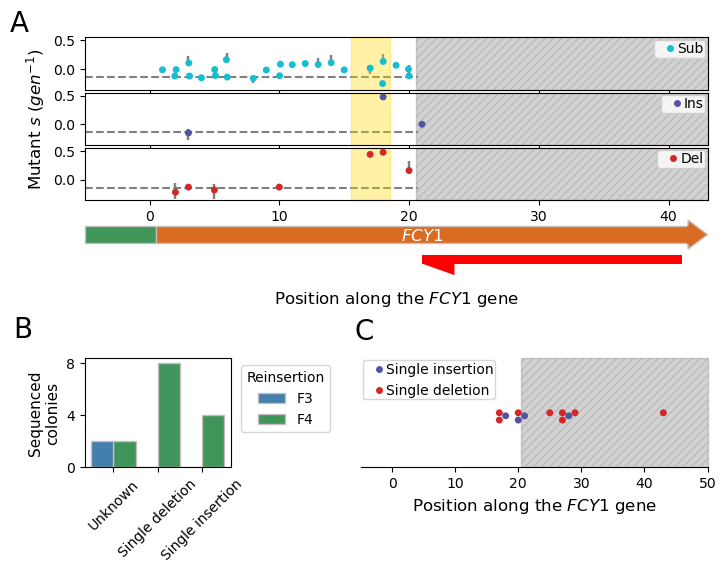

In [18]:
fig = plt.figure(constrained_layout=False, figsize=(6.48, 4.98))

# First row, for A panel
gs1 = fig.add_gridspec(nrows=11, ncols=26, left=0, right=1, bottom=0.55, top=0.95 )
# Second row, for B and C
gs2 = fig.add_gridspec(nrows=9, ncols=26, left=0, right=1, bottom=0.05, top=0.45 )

# axes for A
ax1 = fig.add_subplot(gs1[1:4, 1:26])
ax2 = fig.add_subplot(gs1[4:7, 1:26], sharey=ax1, sharex=ax1)
ax3 = fig.add_subplot(gs1[7:10, 1:26], sharey=ax1, sharex=ax1)

# axes for B and C
ax4 = fig.add_subplot(gs2[4:11, 1:7])
ax5 = fig.add_subplot(gs2[4:11, 12:26])

# Plotting A
sns.stripplot(data=sec_sub, x='FCY1_position', y='s_T0toT3_Ref', hue='Mutation type', 
              ax=ax1, s=5, palette=mut_palette, edgecolor='None', native_scale=True)
ax1.errorbar(sec_sub['FCY1_position'], sec_sub['s_T0toT3_Ref'], yerr=sub_err,
             fmt='none', zorder=0, ecolor='grey', linewidth=1.75)
h1, l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, l1, handletextpad=-0.5, title=None, loc="upper right",
           borderaxespad=0.15, borderpad=0.15)
ax1.set_xlim(left=-5, right=43)
ax1.set_ylim(bottom=-0.35, top=0.55)

sns.stripplot(data=sec_ins, x='FCY1_position', y='s_T0toT3_Ref', hue='Mutation type', 
              ax=ax2, s=5, palette=mut_palette, edgecolor='None', native_scale=True)
ax2.errorbar(sec_ins['FCY1_position'], sec_ins['s_T0toT3_Ref'], yerr=ins_err,
             fmt='none', zorder=0, ecolor='grey', linewidth=1.75)
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h2, l2, handletextpad=-0.5, title=None, loc="upper right",
           borderaxespad=0.15, borderpad=0.15)

sns.stripplot(data=sec_del, x='FCY1_position', y='s_T0toT3_Ref', hue='Mutation type', 
              ax=ax3, s=5, palette=mut_palette, edgecolor='None', native_scale=True)
ax3.errorbar(sec_del['FCY1_position'], sec_del['s_T0toT3_Ref'], yerr=del_err,
             fmt='none', zorder=0, ecolor='grey', linewidth=1.75)
h3, l3 = ax3.get_legend_handles_labels()
ax3.legend(h3, l3, handletextpad=-0.5, title=None, loc="upper right",
           borderaxespad=0.15, borderpad=0.15)

# Adding the F4 and FCY1 rectangles
ax3.add_patch(Rectangle((-5, -0.80), 5.5, -0.30, facecolor='#3f955a', edgecolor='#c8bdbd', clip_on=False))  # F4
ax3.add_patch(Rectangle((0.5, -0.80), 41, -0.30, facecolor='#d45400dc', edgecolor='#c8bdbd', clip_on=False))  # FCY1
ax3.add_patch(Polygon([[41.5, -0.70], [41.5, -1.20], [43, -0.95]], facecolor='#d45400dc', edgecolor='#c8bdbd', clip_on=False))
ax3.plot([41.5, 41.5], [-1.095525, -0.825], c='white', zorder=2, linewidth=1.45, clip_on=False)
ax3.plot([41.5, 41.5], [-1.095525, -0.825], c='#d45400dc', zorder=3, linewidth=1.50, clip_on=False)
ax3.annotate(r"$\it{FCY1}$", (21, -0.975), annotation_clip=False, color='white', ha='center', va='center',
             fontsize=12, zorder=1)

# Adding the reverse primer
ax3.add_patch(Rectangle((21, -1.30), 20, -0.15, facecolor='red', edgecolor=None, clip_on=False))
ax3.add_patch(Polygon([[21, -1.45], [23.5, -1.65], [23.5, -1.30]], facecolor='red', edgecolor=None, clip_on=False))

# Adding median s, hatching the "unseen" region and identifying the second methionine
for ax_150 in [ax1, ax2, ax3]:
    ax_150.axhline(y=med_s, xmin=0, xmax=0.535, c='grey', linestyle='--')
    ax_150.add_patch(Rectangle((20.5, -0.35), 22.5, (0.35+0.55), color='grey', hatch='////', 
                               hatch_linewidth=0.75, alpha=0.35, clip_on=False, zorder=2))
    ax_150.add_patch(Rectangle((15.5, -0.35), 3, (0.35+0.55), color='gold', alpha=0.35, clip_on=False, zorder=2))


# Setting up axis labels
ax1.set_ylabel('')
ax2.set_ylabel(r"Mutant $s$ ($gen^{-1}$)", fontsize=12)
ax3.set_ylabel('')
ax3.set_xlabel(r"Position along the $\it{FCY1}$ gene", labelpad=47.5, fontsize=12)
    
# Plotting B
hist_sanger = sns.histplot(data=data_sanger, x='Mut_type', hue='Reinsertion',
                           multiple='dodge', palette=fragments_palette,
                           alpha=1, edgecolor='#c8bdbd', ax=ax4)
sns.move_legend(hist_sanger, "upper left", bbox_to_anchor=(1.02, 1))
ax4.set_ylabel('Sequenced\ncolonies', fontsize=11)
ax4.set_xlabel('')
ax4.tick_params(axis='x', labelrotation=45)
ax4.set_yticks([0, 4, 8], labels=[0, 4, 8], fontsize=10)

# Plotting C
sanger_to_plot = data_sanger[data_sanger['Mut_type'] != 'Unknown'].copy().reset_index(drop=True)
sns.swarmplot(data=sanger_to_plot, x='FCY1_position', hue='Mut_type', palette=sanger_palette, hue_order=['Single insertion', 'Single deletion'], ax=ax5)
ax5.set_xlim(left=-5, right=50)
h5, l5 = ax5.get_legend_handles_labels()
ax5.legend(h5, l5, handletextpad=-0.5, title=None, loc="upper left",
           borderaxespad=0.15, borderpad=0.15)
ax5.set_xlabel(r"Position along the $\it{FCY1}$ gene", fontsize=12)
ax5.add_patch(Rectangle((20.5, 0.5), 29.5, (-1), color='grey', hatch='////', 
                           hatch_linewidth=0.75, alpha=0.35, clip_on=False, zorder=2))
ax5.spines['left'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.tick_params(axis='y', which='both', left=False, labelleft=False)

# Identifying each plot
ax1.annotate('A', (-10.75, 0.65), annotation_clip=False, fontsize=20)
ax4.annotate('B', (-2.25, 10), annotation_clip=False, fontsize=20)
ax5.annotate('C', (-6, -0.675), annotation_clip=False, fontsize=20)

FigS7 = plt.gcf()
FigS7.savefig('Supp_figs/S7Fig.tiff', bbox_inches='tight')

## S8 Fig

### Preparing data for panel A

In [21]:
# Final selection coefficients from 300 paired-end sequencing
s_no_out_300 = pd.read_csv("Supp_data/s_300_5FC_no_out.csv", index_col=None)

# Keeping only columns of interest
s_300 = s_no_out_300[['Genotype', 's_T0toT1_Ref', 's_T0toT2_Ref', 's_T0toT3_Ref', 'N_T0',
                      'Alias', 'Bio_rep', 'Tech_rep', 'Mutation type', 'Position', 'In F3F4']].copy()
# Kepping only F3F4 single mutants
s_300 = s_300[s_300['In F3F4']].copy().reset_index(drop=True)
# The data in this dataframe is already only for samples with 5-FC and without spike-ins

# Adding a "samp_id" column
s_300['samp_id'] =s_300['Bio_rep'].astype('str') + s_300['Tech_rep']

In [22]:
# Obtaining df of selection coefficients where the time interval is in a column (to be used as hue)
time_int_rename = {'s_T0toT1_Ref':'T0-T1', 's_T0toT2_Ref':'T0-T2', 's_T0toT3_Ref':'T0-T3'}
s_300_by_timepoint = s_300[['samp_id', 'Genotype', 's_T0toT1_Ref', 's_T0toT2_Ref', 's_T0toT3_Ref']].copy()
s_300_by_timepoint = s_300_by_timepoint.rename(columns=time_int_rename)
s_300_by_timepoint = pd.melt(s_300_by_timepoint, id_vars=['samp_id', 'Genotype'],
                             value_vars=['T0-T1', 'T0-T2', 'T0-T3'],
                             var_name='Time interval', value_name='Selection coefficients')

### Preparing data for panel B

In [24]:
# WT-relative frequencies throughout the experiment (300 paired-end sequencing)
freqs_300 = pd.read_csv("Data_compiled_25-04-08/freqs_all_1n_FCY1_300_final.csv").rename(columns={'Mutations': 'Genotype'})
# Reformatting the 'Library' column, to be simply L{lib_number}
freqs_300['Library'] = freqs_300['Library'].apply(lambda x: x.split('_')[1])

In [25]:
# Keeping only the data for cultures with 5-FC and without spike-ins
libs_with5FC = ['L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19']
F3F4_300_5FC = freqs_300[freqs_300['Library'].isin(libs_with5FC)].copy().reset_index(drop=True)
F3F4_300_5FC['samp_id'] =F3F4_300_5FC['Bio_rep'].astype('str') + F3F4_300_5FC['Tech_rep']

In [26]:
# Merging with s_300 to have the corresponding read numbers at T0
F3F4_300_5FC = pd.merge(F3F4_300_5FC, s_300[['Alias', 'Genotype', 'N_T0']], how='right', on=['Alias', 'Genotype']).dropna(subset=['N_T0']).reset_index(drop=True)

In [27]:
# Defining a function to plot all the trajectories of WT-relative frequencies for a library
def plot_traj_lib(df, lib, lib_col, id_col, freq_col, time_col, time_dict, hue_col, ax, hue_label=None, log_hue=True, cbar_fontsize=12):
    # Constructing the vectors of time labels that will be used
    timepoints_list = list(time_dict[lib].keys())
    timepoints_list.sort()
    times_vect = np.array([time_dict[lib][x] for x in timepoints_list])

    # Copying the df to avoid modifying the original object
    df_within = df.copy()
    
    # Log scaling the relative frequency
    df_within[freq_col] = np.log(df_within[freq_col])
    
    # Finding the min and max which will be used for the ylimits
    freq_min = np.min(df_within[freq_col])
    freq_max = np.max(df_within[freq_col])
    
    # Selecting data for the chosen lib
    data_lib = df_within[df_within[lib_col] == lib].copy().reset_index(drop=True)
    id_lib = data_lib[id_col].unique()
    if len(id_lib) != 1:
        raise Exception('There should only one value of id_col for the specified lib.')
    else:
        id_plot = id_lib[0]

    # Log10 scaling of the hue column, if necessary
    if log_hue:
        data_lib[hue_col] = np.log10(data_lib[hue_col])
        data_lib = data_lib.rename(columns={f'{hue_col}': f'Log10_{hue_col}'})

    # Obtaining all the lines to be plotted
    lines_data = []
    hue_array = []
    
    for var_id in data_lib['Genotype'].unique():
        var_subset = data_lib[data_lib['Genotype'] == var_id].copy().reset_index(drop=True)
                
        freq_vect = []
                
        for timepoint in timepoints_list:
            time_subset = var_subset[var_subset[time_col] == timepoint].copy().reset_index(drop=True)
            
            if not time_subset.empty:
                freq_vect += [time_subset.at[0, freq_col]]
            elif time_subset.empty:
                freq_vect += [np.nan]
                        
        lines_data += [np.column_stack([times_vect, np.array(freq_vect)])]
        hue_array += [np.mean(var_subset[f'Log10_{hue_col}'])]  # This assumes that this value is the same across data points

    # Preparing the LineCollection to be plotted
    line_segments = LineCollection(np.array(lines_data), array=np.array(hue_array), alpha=0.35, linewidth=0.15)

    # Plotting the line collection and setting the figure
    fig_obj = ax.add_collection(line_segments)
            
    ax.set_facecolor('darkgrey')
    ax.set_xlim(0, np.max(times_vect)+0.05)
    ax.set_ylim(freq_min, freq_max)
    ax.set_xticks([0, time_dict[lib]['T1'], time_dict[lib]['T2'], time_dict[lib]['T3']], labels=['T0', 'T1', 'T2', 'T3'])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar_traj = fig.colorbar(fig_obj, cax=cax, orientation='vertical')

    if hue_label:
        cbar_traj.set_label(f"{hue_label}", size=cbar_fontsize)
        
    ax.set_title(f'{id_plot}')

In [28]:
# Making the time_dict
gen_time_df = pd.read_csv("Gen_time_df.csv")
time_dict_300 = {}

# Adding the corresponding time data
for lib_name in F3F4_300_5FC['Library'].unique():
    time_subset = gen_time_df[gen_time_df['Library']==lib_name].copy().reset_index(drop=True)
    current_dict = {'T0': 0, 'T1': time_subset['T1_gen_ref'].values[0],
                    'T2': time_subset['T2_gen_ref'].values[0],
                    'T3': time_subset['T3_gen_ref'].values[0]}
    time_dict_300[lib_name] = current_dict

In [29]:
time_dict_300

{'L19': {'T0': 0,
  'T1': 5.463208107895501,
  'T2': 9.915500617412686,
  'T3': 13.571981330141794},
 'L13': {'T0': 0,
  'T1': 5.463208107895501,
  'T2': 10.001526651813966,
  'T3': 13.442903562952836},
 'L17': {'T0': 0,
  'T1': 5.592260064693101,
  'T2': 10.195104587010366,
  'T3': 13.916111278138272},
 'L15': {'T0': 0,
  'T1': 5.205104194300303,
  'T2': 9.915500617412686,
  'T3': 13.313877416546594},
 'L18': {'T0': 0,
  'T1': 5.592260064693101,
  'T2': 10.324156543807966,
  'T3': 13.916111278138272},
 'L14': {'T0': 0,
  'T1': 5.463208107895501,
  'T2': 9.691801955499727,
  'T3': 12.905195679759958},
 'L12': {'T0': 0,
  'T1': 5.592260064693101,
  'T2': 10.195104587010366,
  'T3': 13.636481498149235},
 'L16': {'T0': 0,
  'T1': 5.205104194300303,
  'T2': 9.915500617412686,
  'T3': 13.442929373344194}}

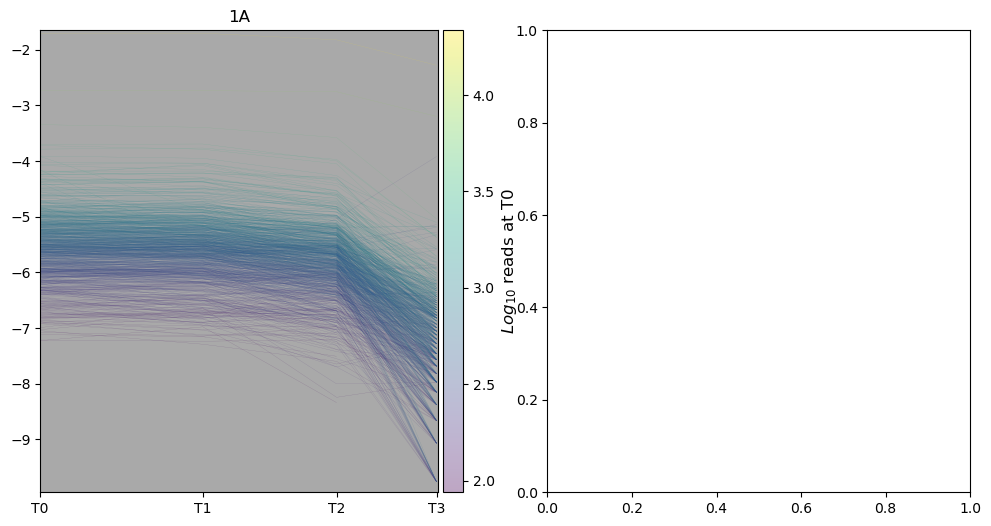

In [30]:
fig, axs = plt.subplots(1,2, figsize=(12, 6))

plot_traj_lib(F3F4_300_5FC, 'L12', 'Library', 'samp_id', 'Rel_wt', 'Timepoint', time_dict_300, 'N_T0', axs[0], hue_label=r"$Log_{10}$ reads at T0", log_hue=True)


### Constructing the figure

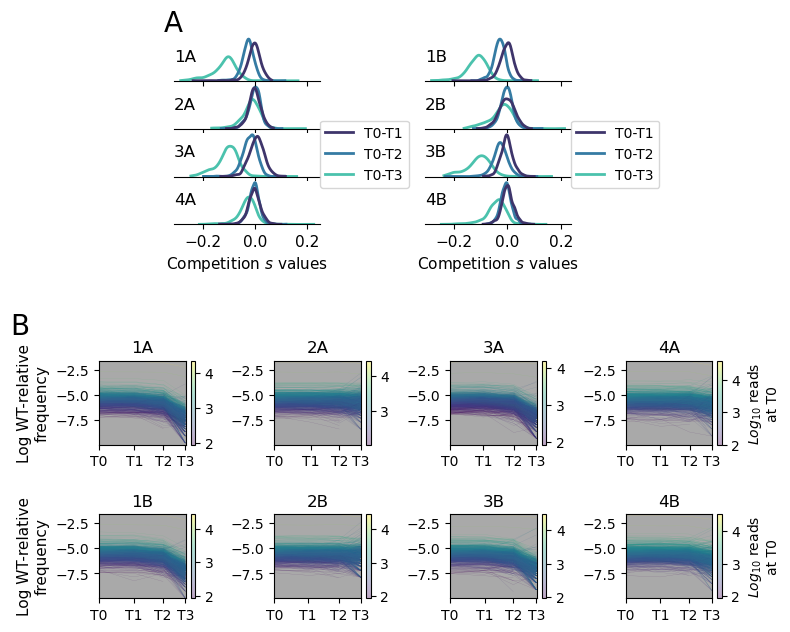

In [70]:
fig = plt.figure(constrained_layout=False, figsize=(6.48, 6.48))

# First row, for A panel
gs1 = fig.add_gridspec(nrows=11, ncols=26, left=0, right=1, bottom=0.55, top=0.95 )
# Second row, for B 
gs2 = fig.add_gridspec(nrows=12, ncols=26, left=0, right=1, bottom=0.05, top=0.45 )

# axes for distributions of selection coefficients
ax1 = fig.add_subplot(gs1[0:2, 4:10])
ax2 = fig.add_subplot(gs1[2:4, 4:10], sharex=ax1)
ax3 = fig.add_subplot(gs1[4:6, 4:10], sharex=ax1)
ax4 = fig.add_subplot(gs1[6:8, 4:10], sharex=ax1)
ax5 = fig.add_subplot(gs1[0:2, 14:20])
ax6 = fig.add_subplot(gs1[2:4, 14:20], sharex=ax5)
ax7 = fig.add_subplot(gs1[4:6, 14:20], sharex=ax5)
ax8 = fig.add_subplot(gs1[6:8, 14:20], sharex=ax5)

# axes for trajectories of WT-relative frequencies
ax9 = fig.add_subplot(gs2[0:4, 1:5])
ax10 = fig.add_subplot(gs2[7:11, 1:5])
ax11 = fig.add_subplot(gs2[0:4, 8:12], sharey=ax9)
ax12 = fig.add_subplot(gs2[7:11, 8:12], sharey=ax10)
ax13 = fig.add_subplot(gs2[0:4, 15:19], sharey=ax9)
ax14 = fig.add_subplot(gs2[7:11, 15:19], sharey=ax10)
ax15 = fig.add_subplot(gs2[0:4, 22:26], sharey=ax9)
ax16 = fig.add_subplot(gs2[7:11, 22:26], sharey=ax10)

# Making plots for part A
axes_a = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for ax_num, lib_id in enumerate(['1A', '2A', '3A', '4A', '1B', '2B', '3B', '4B']):
    s_subset = s_300_by_timepoint[s_300_by_timepoint['samp_id'] == lib_id].copy().reset_index(drop=True)

    axes_a[ax_num].spines['left'].set_visible(False)
    axes_a[ax_num].spines['right'].set_visible(False)
    axes_a[ax_num].spines['top'].set_visible(False)

    axes_a[ax_num].annotate(f'{lib_id}', (0, 0.45), xycoords='axes fraction', fontsize=12)
    
    if ax_num != 3 and ax_num !=7:
        axes_a[ax_num].tick_params(left=False, labelleft=False, bottom=True, labelbottom=False, top=False, labeltop=False,
                                   right=False, labelright=False)
    elif ax_num == 3 or ax_num == 7:
        axes_a[ax_num].tick_params(left=False, labelleft=False, bottom=True, labelbottom=True, top=False, labeltop=False,
                                   right=False, labelright=False)

    if ax_num == 0 or ax_num == 4:
        kde_data = sns.kdeplot(s_subset, x='Selection coefficients', hue='Time interval',
                               palette='mako', ax=axes_a[ax_num], cut=0, linewidth=2)

    else:
        sns.kdeplot(s_subset, x='Selection coefficients', hue='Time interval',
                    palette='mako', ax=axes_a[ax_num], cut=0, linewidth=2, legend=False)

ax1.set_zorder(3)
ax1.get_legend().set(title=None, bbox_to_anchor=(1.65, -0.75), loc='upper right')
ax4.set_xlabel(r"Competition $s$ values", fontsize=11)
ax4.tick_params(axis='x', labelsize=11)

ax5.set_zorder(3)
ax5.get_legend().set(title=None, bbox_to_anchor=(1.65, -0.75), loc='upper right')
ax8.set_xlabel(r"Competition $s$ values", fontsize=11)
ax8.tick_params(axis='x', labelsize=11)

# Making plots for part B
axes_b = [ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16]
for ax_num, lib_id in enumerate(['L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19']):

    current_ax = axes_b[ax_num]

    if current_ax == ax15 or current_ax == ax16:
        plot_traj_lib(F3F4_300_5FC, lib_id, 'Library', 'samp_id', 'Rel_wt', 'Timepoint', time_dict_300, 'N_T0', 
                      axes_b[ax_num], hue_label=r"$Log_{10}$ reads"'\n'"at T0", log_hue=True, cbar_fontsize=10)
    else:
         plot_traj_lib(F3F4_300_5FC, lib_id, 'Library', 'samp_id', 'Rel_wt', 'Timepoint', time_dict_300, 'N_T0', 
                       axes_b[ax_num], log_hue=True, cbar_fontsize=9)

ax9.set_ylabel('Log WT-relative\nfrequency', fontsize=11)
ax10.set_ylabel('Log WT-relative\nfrequency', fontsize=11)

# Identifying the two panels
ax1.annotate('A', (-0.35, 7.5), annotation_clip=False, fontsize=20)
ax9.annotate('B', (-14, 1), annotation_clip=False, fontsize=20)

FigS8 = plt.gcf()
FigS8.savefig('Supp_figs/S8Fig.tiff', bbox_inches='tight')

In [33]:
meds_s = s_300_by_timepoint.drop(columns=['Genotype']).groupby(by=['samp_id', 'Time interval'], as_index=False).median()
meds_s.sort_values(by=['Time interval'], ascending=False)

,samp_id,Time interval,Selection coefficients
23,4B,T0-T3,-0.036852
5,1B,T0-T3,-0.110070
14,3A,T0-T3,-0.101894
11,2B,T0-T3,-0.016448
8,2A,T0-T3,-0.011713
20,4A,T0-T3,-0.026590
2,1A,T0-T3,-0.109904
17,3B,T0-T3,-0.102141
7,2A,T0-T2,-0.000898
4,1B,T0-T2,-0.028573


-0.075 is a decent threshold to define a replicate as 'biased'